In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import pandas as pd
from timeit import default_timer
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})


/opt/miniconda3/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [10]:
def open_gain(date, date_idx):
    year, month, day = date.year, date.month, date.day
    PATH = f"/pscratch/sd/a/amahesh/hens_h5/paralleltrials_gain_grid_cell/gain_t2m_{year}{month:02d}{day:02d}_reduced-lead-10.h5"
    ds = xr.open_dataset(PATH)
    hens = ds['t2m_gain'].isel(phony_dim_0=date_idx, phony_dim_1=0).mean('phony_dim_2')
    small = ds['t2m_gain'].isel(phony_dim_0=date_idx, phony_dim_1=1).mean('phony_dim_2')
    return hens, small

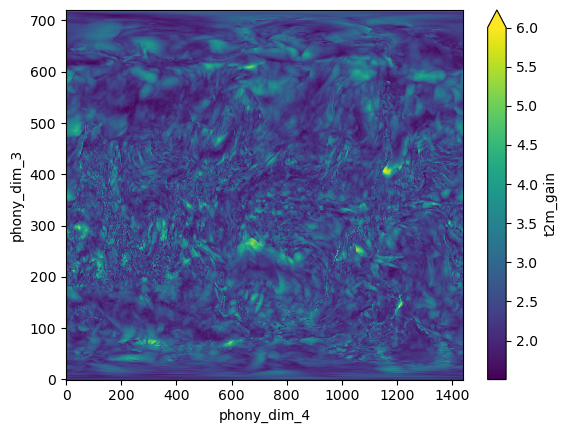

In [4]:
ds = xr.open_dataset("/pscratch/sd/a/amahesh/hens_h5/paralleltrials_gain_grid_cell/gain_t2m_20230601_reduced-lead-10.h5")
ds['t2m_gain'].isel(phony_dim_0=0, phony_dim_1=1, phony_dim_2=0).plot(vmax=6)

In [7]:
dates = pd.date_range('2023-06-01', '2023-08-31', freq='D')

In [23]:
hens_gains, small_gains = [], []
for date_idx, date in enumerate(dates):
    start = default_timer()
    hens, small = open_gain(date, date_idx)
    hens_gains.append(hens)
    small_gains.append(small)
    print(date_idx, default_timer() - start)

0 10.980334711028263
1 10.882252389099449
2 10.603754690848291
3 17.52536832797341
4 25.256071883020923
5 24.490198774030432
6 24.394088180968538
7 25.231667501851916
8 24.590064908843488
9 25.29442891990766
10 25.171331712044775
11 25.871884574880823
12 25.229737549088895
13 25.55697486293502
14 25.543917605187744
15 25.66003627004102
16 25.84713988681324
17 25.716552010038868
18 25.8607895381283
19 25.867473408812657
20 24.643894725944847
21 24.40136382705532
22 24.400048308074474
23 24.384014968993142
24 24.835813459940255
25 24.831564991967753
26 24.77114810119383
27 24.76432287110947
28 24.352904396131635
29 24.193617946933955
30 25.62747625191696
31 30.921159664867446
32 26.471861317986622
33 27.203090855153278
34 25.28407137002796
35 25.65146026806906
36 25.905669284053147
37 28.074307943927124
38 24.7470385520719
39 24.304598773131147
40 25.216810102807358
41 26.62251084204763
42 25.77744657313451
43 27.741376769030467
44 26.674056389834732
45 26.60054007009603
46 27.3246186699

In [24]:
hens_gains_xr = xr.concat(hens_gains, dim='initial_time')
small_gains_xr = xr.concat(small_gains, dim='initial_time')


In [26]:
hens_gains_xr.to_zarr("/pscratch/sd/a/amahesh/temp/hens_gains_gridcell.zarr")
small_gains_xr.to_zarr("/pscratch/sd/a/amahesh/temp/small_gains_gridcell.zarr")


In [6]:
hens_gains_xr = xr.open_zarr("/pscratch/sd/a/amahesh/temp/hens_gains_gridcell.zarr")['t2m_gain']
small_gains_xr = xr.open_zarr("/pscratch/sd/a/amahesh/temp/small_gains_gridcell.zarr")['t2m_gain']


In [7]:
dummy = xr.open_mfdataset("/pscratch/sd/a/amahesh/hens/demo_bred_1step/ensemble_out_0000*_2020-06-18-00-00-00.nc",
                     group='global', concat_dim='ensemble', combine='nested')

In [8]:
hens_gains_xr = hens_gains_xr.rename({'phony_dim_3' : 'lat', 
                      'phony_dim_4' : 'lon'})
small_gains_xr = small_gains_xr.rename({'phony_dim_3' : 'lat', 
                      'phony_dim_4' : 'lon'})
hens_gains_xr['lat'] = dummy['lat']
hens_gains_xr['lon'] = dummy['lon']
small_gains_xr['lon'] = dummy['lon']
small_gains_xr['lat'] = dummy['lat']


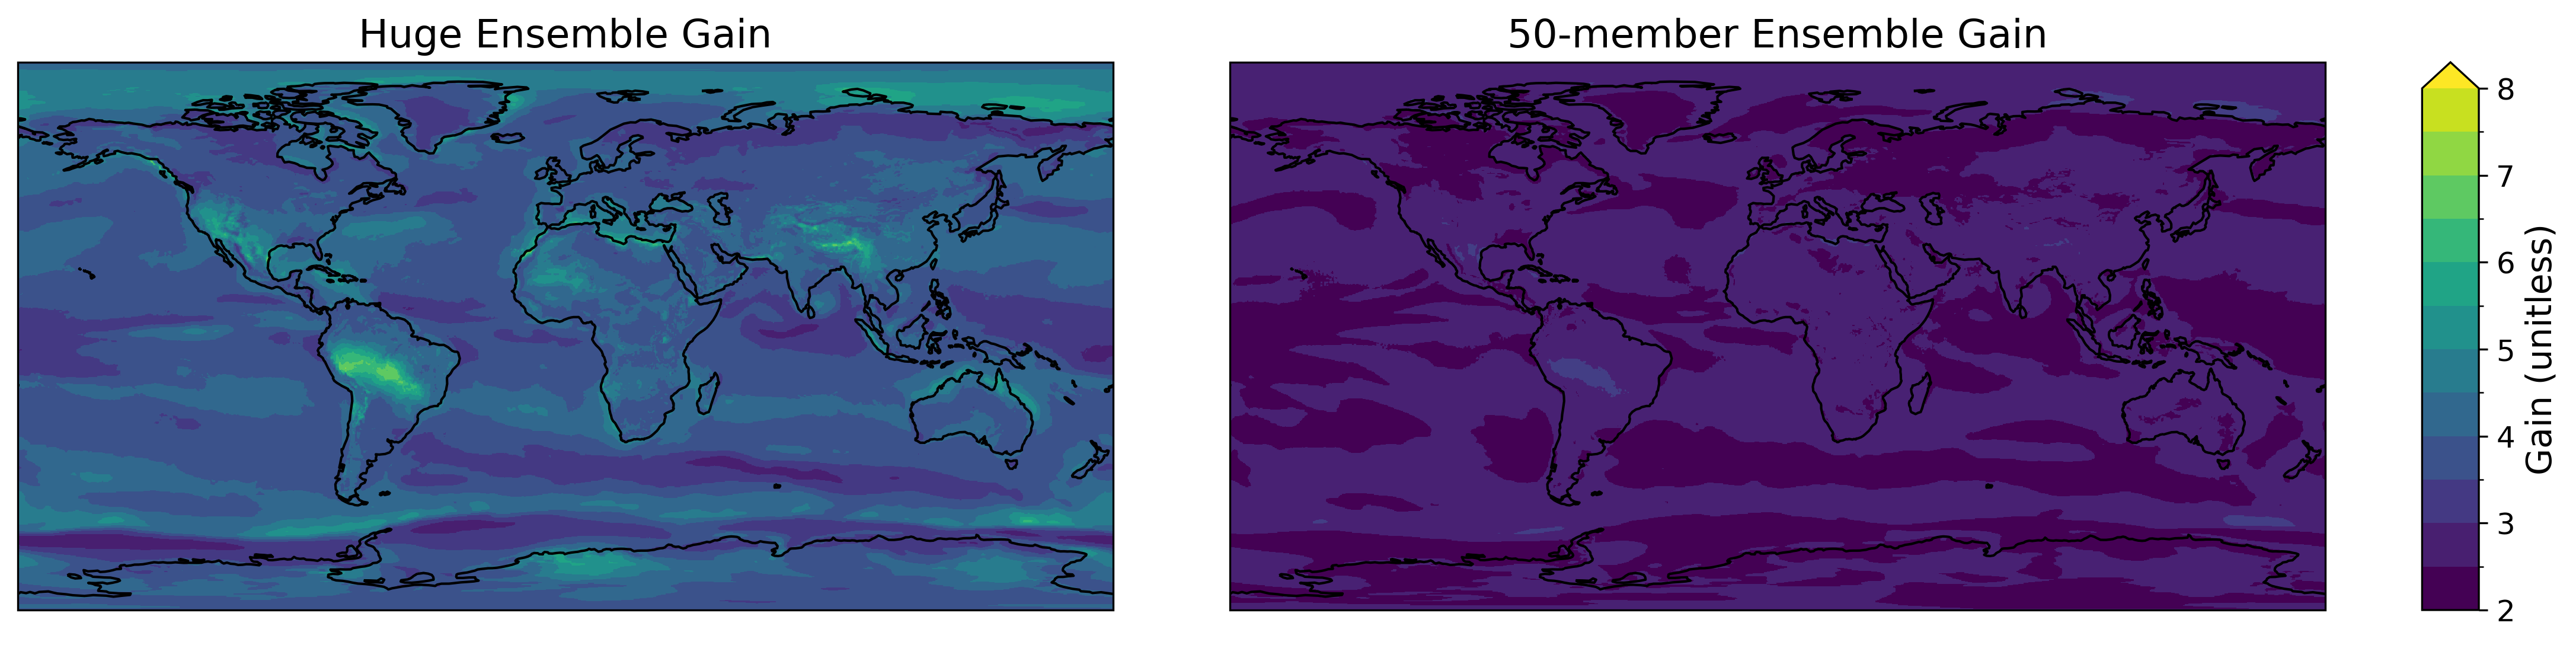

In [12]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import gridspec

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13
})

# Create the figure and subplots
fig = plt.figure(figsize=(18, 4), dpi=300)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)

ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

# Plot the data on the first subplot
im1 = hens_gains_xr.mean('initial_time').plot(ax=ax, vmin=2, vmax=8, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False,
                                              levels=np.arange(2,8.01,0.5))
ax.coastlines()
ax.set_title("Huge Ensemble Gain")

# Plot the data on the second subplot
im2 = small_gains_xr.mean('initial_time').plot(ax=ax2, vmin=2, vmax=8, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False,
                                              levels=np.arange(2,8.01,0.5))
ax2.coastlines()
ax2.set_title("50-member Ensemble Gain")

# Add a single colorbar for both subplots
cbar_ax = fig.add_subplot(gs[2])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Gain (unitless)')

plt.show()



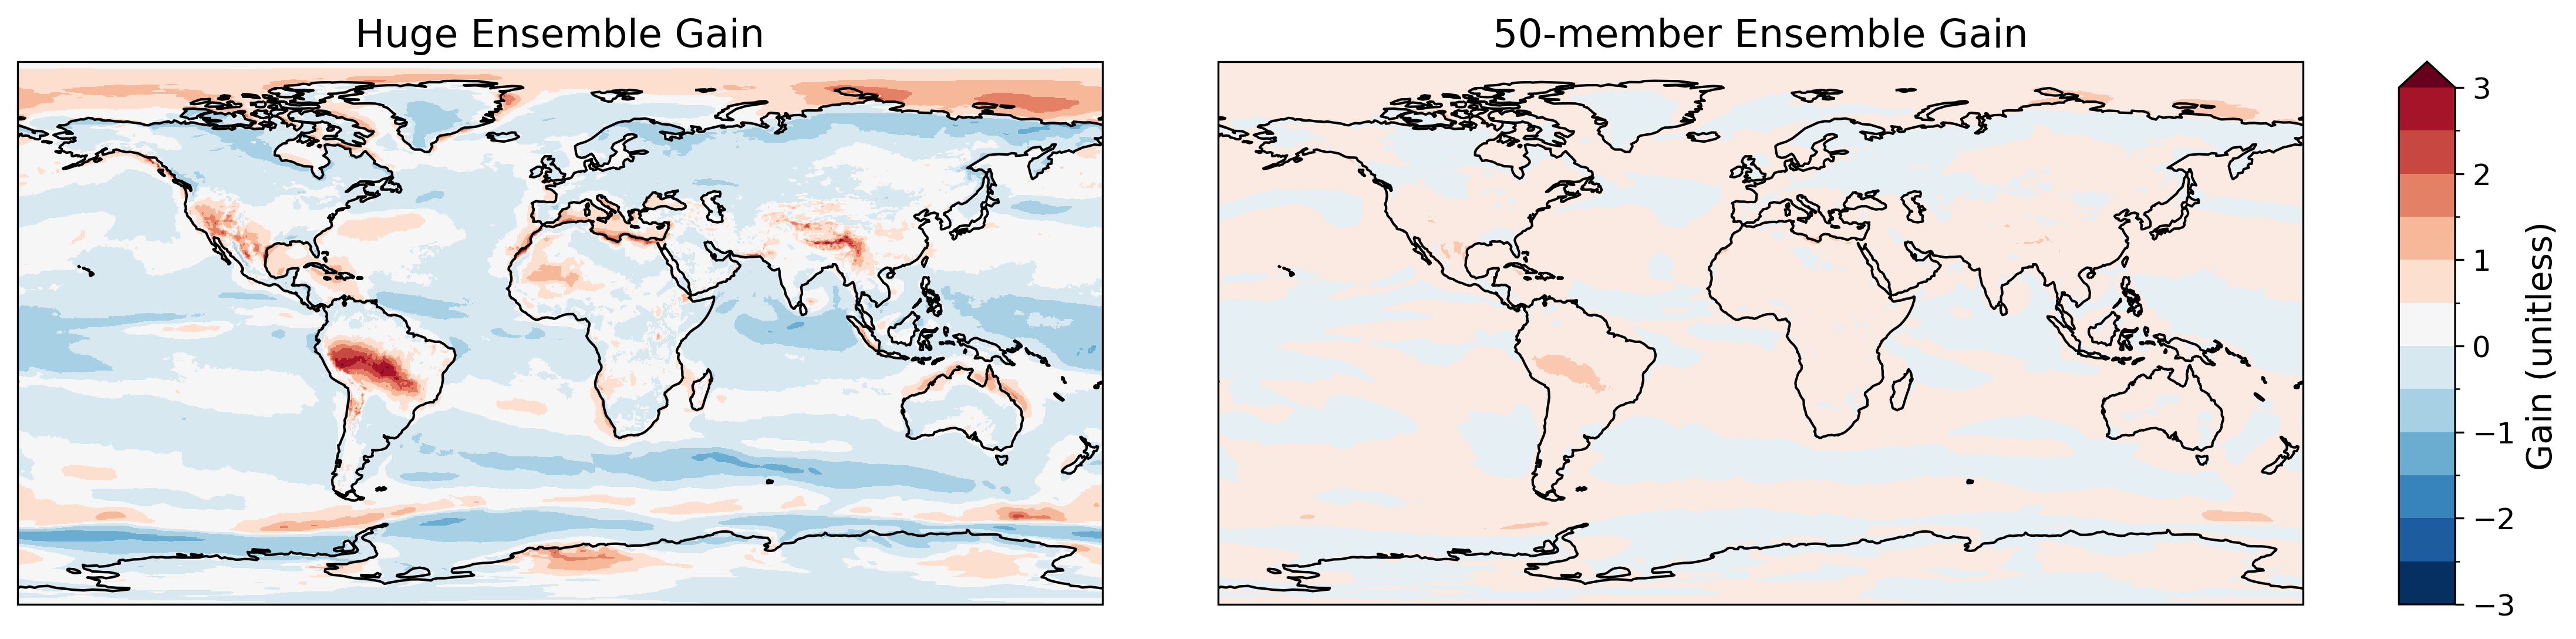

In [15]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import gridspec

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13
})

# Create the figure and subplots
fig = plt.figure(figsize=(18, 4), dpi=300)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)

ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

# Plot the data on the first subplot
im1 = (hens_gains_xr.mean('initial_time') - 3.92).plot(ax=ax, vmin=-3, vmax=3, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False,
                                              levels=np.arange(-3,3.01,0.5))
ax.coastlines()
ax.set_title("Huge Ensemble Gain")

# Plot the data on the second subplot
im2 = (small_gains_xr.mean('initial_time') - 2.5).plot(ax=ax2, vmin=-3, vmax=3, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False,
                                              levels=np.arange(-3, 3.01,0.5))
ax2.coastlines()
ax2.set_title("50-member Ensemble Gain")

# Add a single colorbar for both subplots
cbar_ax = fig.add_subplot(gs[2])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Gain (unitless)')

plt.show()



In [16]:
weights = np.cos(np.deg2rad(hens_gains_xr.lat))
hens_gains_xr.mean('initial_time').weighted(weights).mean().values

array(3.9262424, dtype=float32)

In [17]:
weights = np.cos(np.deg2rad(hens_gains_xr.lat))
small_gains_xr.mean('initial_time').weighted(weights).mean().values

array(2.5431802, dtype=float32)

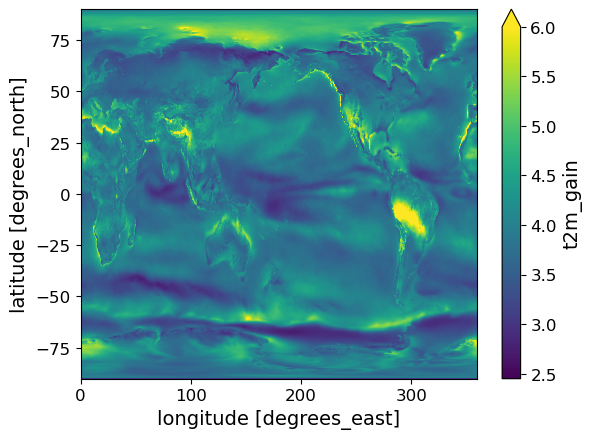

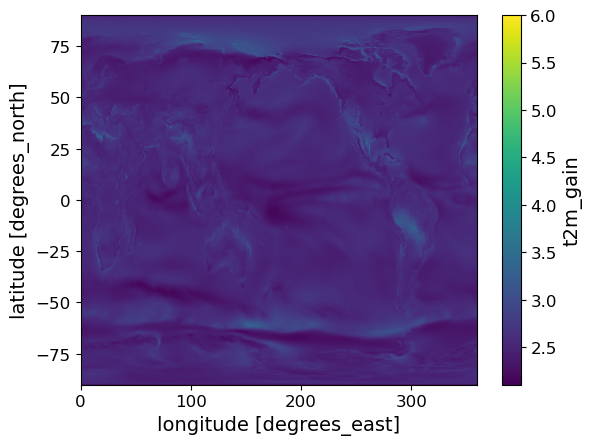

In [41]:

hens_gains_xr.mean('initial_time').plot(vmax=6)
plt.show()
small_gains_xr.mean('initial_time').plot(vmax=6)

In [45]:
hens_gains_xr.mean('initial_time').max()

<xarray.DataArray 't2m_gain' ()> Size: 8B
array(8.18612099)